In [ ]:
import rasterio
from rasterio.windows import Window
import numpy as np
import json
import os
from pathlib import Path
import random

## import the function
from patchify import create_and_save_patches, get_patch_bounds_from_metadata, get_transform
from bitmap import generate_bitmaps_for_patches

ImportError: cannot import name 'get_patch_bounds_from_metadata' from 'patchify' (/mnt/d/desktop/drone-mapping/code/dev/patchify.py)

In [2]:
os.getcwd()

'/mnt/d/desktop/drone-mapping/code/dev'

In [ ]:
## import the func

In [3]:
patch_metadata = create_and_save_patches(
    cog_path='big-tiles/tile_1.tif',
    output_dir='./newdataset_overlap',
    patch_size=512,
    overlap=64
)

Original image: 20729x34287, 3 bands
Original transform: | 0.04, 0.00,-4818800.61|
| 0.00,-0.04,-2585159.69|
| 0.00, 0.00, 1.00|

DEBUG - First patch (ID 0):
  Window: Window(col_off=0, row_off=0, width=512, height=512)
  Patch transform: | 0.04, 0.00,-4818800.61|
| 0.00,-0.04,-2585159.69|
| 0.00, 0.00, 1.00|
  Patch pixel (0,0) -> geo(-4818800.61, -2585159.69)
  Patch pixel (512,512) -> geo(-4818780.04, -2585180.26)
  Inverse check: geo(-4818800.61, -2585159.69) -> pixel(0.00, 0.00)
Created 100 patches...
Created 200 patches...
Created 300 patches...
Created 400 patches...
Created 500 patches...
Created 600 patches...
Created 700 patches...
Created 800 patches...
Created 900 patches...
Created 1000 patches...
Created 1100 patches...
Created 1200 patches...
Created 1300 patches...
Created 1400 patches...
Created 1500 patches...
Created 1600 patches...
Created 1700 patches...
Created 1800 patches...
Created 1900 patches...
Created 2000 patches...
Created 2100 patches...
Created 2200 pat

## Visualize patch

In [4]:
import matplotlib.pyplot as plt
import cv2

In [41]:
list_files =[]
for dirpath, dirs, files in os.walk('/mnt/d/desktop/drone-mapping/code/dev/newdataset_overlap'): 
  for filename in files:
    fname = os.path.join(dirpath,filename)
    if fname.endswith('.jpg'):
      list_files.append(fname)

patch_003331.jpg


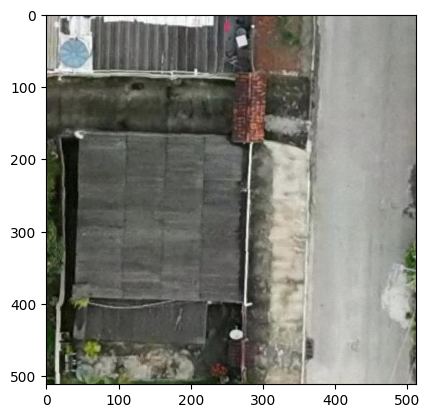

In [45]:
## show random image from list of paths
img_path = random.sample(list_files,1)[0]
img = cv2.imread(img_path)
print(img_path.split('/')[-1])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #convert BGR to RGB
plt.imshow(img)

## Patching Building Footprint

## load metadata

In [ ]:
import json
with open('./newdataset_overlap/metadata/patches_metadata.json') as f:
    patch_metadata = json.load(f)
    
    

In [140]:
from rasterio.transform import Affine
import pandas as pd
def create_patch_gdf(patch_metadata, include_bounds_columns=True):
    """
    Create a GeoDataFrame from patch metadata
    
    Parameters:
    - patch_metadata: list of patch metadata dictionaries or path to JSON file
    - include_bounds_columns: whether to include separate minx, miny, maxx, maxy columns
    
    Returns:
    - GeoDataFrame with patch polygons and metadata
    """
    
    # Load metadata if it's a file path
    if isinstance(patch_metadata, (str, Path)):
        with open(patch_metadata, 'r') as f:
            patch_metadata = json.load(f)
    
    # Lists to store data
    geometries = []
    patch_data = []
    
    print(f"Processing {len(patch_metadata)} patches...")
    
    for patch in patch_metadata:
        # Extract patch info
        patch_id = patch['patch_id']
        filename = patch['filename']
        
        # Get patch dimensions
        width = patch['original_window']['width']
        height = patch['original_window']['height']
        col_off = patch['original_window']['col_off']
        row_off = patch['original_window']['row_off']
        
        # Get transform and CRS
        transform = Affine(*patch['transform'])
        crs = patch['crs']
        
        # Calculate geographic bounds of the patch
        # Top-left corner (pixel 0,0)
        geo_x_min, geo_y_max = transform * (0, 0)
        
        # Bottom-right corner (pixel width, height)
        geo_x_max, geo_y_min = transform * (width, height)
        
        # Create bounding box polygon
        patch_polygon = box(geo_x_min, geo_y_min, geo_x_max, geo_y_max)
        geometries.append(patch_polygon)
        
        # Prepare row data
        row_data = {
            'patch_id': patch_id,
            'filename': filename,
            'col_off': col_off,
            'row_off': row_off,
            'width': width,
            'height': height,
            'crs': crs,
            'bands': patch['bands'],
            'original_file': patch['original_file'],
            'transform_a': transform.a,  # pixel width
            'transform_b': transform.b,  # rotation
            'transform_c': transform.c,  # x-coordinate of top-left
            'transform_d': transform.d,  # rotation
            'transform_e': transform.e,  # pixel height (negative)
            'transform_f': transform.f,  # y-coordinate of top-left
        }
        
        # Add bounds columns if requested
        if include_bounds_columns:
            row_data.update({
                'minx': geo_x_min,
                'miny': geo_y_min,
                'maxx': geo_x_max,
                'maxy': geo_y_max,
                'center_x': (geo_x_min + geo_x_max) / 2,
                'center_y': (geo_y_min + geo_y_max) / 2,
                'area': patch_polygon.area,
                'perimeter': patch_polygon.length
            })
        
        # Add original transform info if available
        if 'original_transform' in patch:
            orig_transform = Affine(*patch['original_transform'])
            row_data.update({
                'orig_transform_a': orig_transform.a,
                'orig_transform_c': orig_transform.c,
                'orig_transform_f': orig_transform.f,
            })
        
        patch_data.append(row_data)
    
    # Create GeoDataFrame
    df = pd.DataFrame(patch_data)
    gdf = gpd.GeoDataFrame(df, geometry=geometries, crs=crs)
    
    print(f"Created GeoDataFrame with {len(gdf)} patches")
    print(f"CRS: {gdf.crs}")
    print(f"Bounds: {gdf.total_bounds}")
    
    return gdf

In [145]:
gdf = create_patch_gdf(patch_metadata)

Processing 3496 patches...


Created GeoDataFrame with 3496 patches
CRS: EPSG:3857
Bounds: [-4818800.60636553 -2586530.10045018 -4817970.1305054  -2585159.68672434]


In [146]:
gdf.iloc[100].geometry.bounds

(-4818656.622934668,
 -2585216.2516436037,
 -4818636.053873117,
 -2585195.6825820524)

In [8]:
patch_metadata[1]

{'patch_id': 1,
 'filename': 'patch_000001.jpg',
 'original_window': {'col_off': 448,
  'row_off': 0,
  'width': 512,
  'height': 512},
 'transform': [0.04017394834187174,
  0.0,
  -4818782.608436668,
  0.0,
  -0.04017394834187174,
  -2585159.686724338],
 'crs': 'EPSG:3857',
 'bands': [1, 2, 3],
 'original_file': 'big-tiles/tile_1.tif',
 'original_transform': [0.04017394834187174,
  0.0,
  -4818800.606365525,
  0.0,
  -0.04017394834187174,
  -2585159.686724338]}

In [ ]:
## gdf with patch_metadata


## Bitmap - Building Footprint

In [ ]:
import os
import glob
import geopandas as gpd
from shapely.geometry import box, mapping
from rasterio.transform import Affine
from rasterio import features
from shapely.affinity import affine_transform

from plots import print_img, plot_images, plot_pairwise_simple, plot_pairwise
from bitmap import generate_bitmaps_for_patches

In [197]:
for dirpath, dirs, files in os.walk('/mnt/d/Desktop/drone-mapping/data'): 
  for filename in files:
    fname = os.path.join(dirpath,filename)
    if fname.endswith('.shp'):
      print(fname)

/mnt/d/Desktop/drone-mapping/data/shp/building-footprint.shp


In [198]:
## load buildings footprint shp
buildings = gpd.read_file(fname)
buildings["id"] = buildings.index

In [200]:
buildings.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [297]:
## create the spatial join gdf that will hold the whole operation downstream
intersection = buildings.sjoin(gdf, how='left', predicate="intersects")

intersection.head()

,id,geometry,index_right,patch_id,filename,col_off,row_off,width,height,crs,...,miny,maxx,maxy,center_x,center_y,area,perimeter,orig_transform_a,orig_transform_c,orig_transform_f
0,0,"POLYGON ((-4818423.116 -2585875.568, -4818412....",1860,1860,patch_001860.jpg,8960,17920,512,512,EPSG:3857,...,-2.585900e+06,-4.818420e+06,-2.585880e+06,-4.818430e+06,-2.585890e+06,423.086293,82.276246,0.040174,-4.818801e+06,-2.585160e+06
0,0,"POLYGON ((-4818423.116 -2585875.568, -4818412....",1861,1861,patch_001861.jpg,9408,17920,512,512,EPSG:3857,...,-2.585900e+06,-4.818402e+06,-2.585880e+06,-4.818412e+06,-2.585890e+06,423.086293,82.276246,0.040174,-4.818801e+06,-2.585160e+06
0,0,"POLYGON ((-4818423.116 -2585875.568, -4818412....",1814,1814,patch_001814.jpg,8960,17472,512,512,EPSG:3857,...,-2.585882e+06,-4.818420e+06,-2.585862e+06,-4.818430e+06,-2.585872e+06,423.086293,82.276246,0.040174,-4.818801e+06,-2.585160e+06
0,0,"POLYGON ((-4818423.116 -2585875.568, -4818412....",1815,1815,patch_001815.jpg,9408,17472,512,512,EPSG:3857,...,-2.585882e+06,-4.818402e+06,-2.585862e+06,-4.818412e+06,-2.585872e+06,423.086293,82.276246,0.040174,-4.818801e+06,-2.585160e+06
1,1,"POLYGON ((-4818453.708 -2585617.312, -4818445....",1215,1215,patch_001215.jpg,8512,11648,512,512,EPSG:3857,...,-2.585648e+06,-4.818438e+06,-2.585628e+06,-4.818448e+06,-2.585638e+06,423.086293,82.276246,0.040174,-4.818801e+06,-2.585160e+06


In [298]:
## create the bitmap 
results = generate_bitmaps_for_patches(
    intersection,
    output_folder="/mnt/d/desktop/drone-mapping/code/dev/newdataset_overlap/bitmap",
    bitmap_size=(512, 512), 
    fill_value=0, 
    dtype=np.uint8,
    save_format='PNG')

Processing patch 170 (1/313)
  ✓ Saved: patch_000170.png
Processing patch 171 (2/313)
  ✓ Saved: patch_000171.png
Processing patch 199 (3/313)
  ✓ Saved: patch_000199.png
Processing patch 200 (4/313)
  ✓ Saved: patch_000200.png
Processing patch 215 (5/313)
  ✓ Saved: patch_000215.png
Processing patch 216 (6/313)
  ✓ Saved: patch_000216.png
Processing patch 217 (7/313)
  ✓ Saved: patch_000217.png
Processing patch 245 (8/313)
  ✓ Saved: patch_000245.png
Processing patch 246 (9/313)
  ✓ Saved: patch_000246.png
Processing patch 247 (10/313)
  ✓ Saved: patch_000247.png
Processing patch 248 (11/313)
  ✓ Saved: patch_000248.png
Processing patch 261 (12/313)
  ✓ Saved: patch_000261.png
Processing patch 262 (13/313)
  ✓ Saved: patch_000262.png
Processing patch 292 (14/313)
  ✓ Saved: patch_000292.png
Processing patch 293 (15/313)
  ✓ Saved: patch_000293.png
Processing patch 294 (16/313)
  ✓ Saved: patch_000294.png
Processing patch 305 (17/313)
  ✓ Saved: patch_000305.png
Processing patch 306 (1

In [303]:
## Visualize the generated bitmap
dirpath = '/mnt/d/desktop/drone-mapping/code/dev/newdataset_overlap/bitmap'
list_paths = os.listdir(dirpath)
list_paths = [os.path.join(dirpath,path) for path in list_paths]

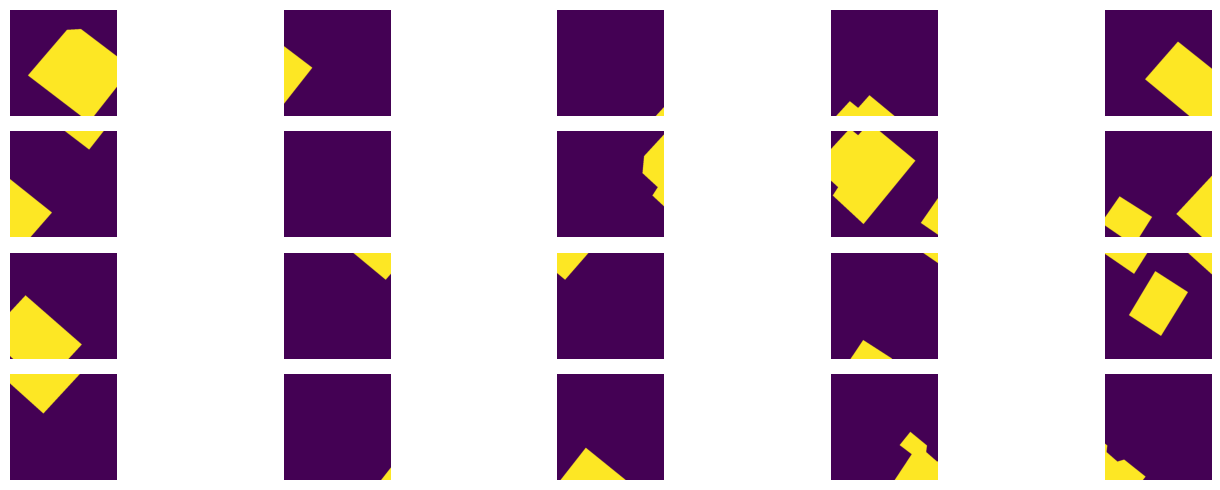

In [310]:
plot_images(list_paths[:20])

In [332]:
## plot pairwise

def retrieve_pair_filename(dir_bitmap= "/mnt/d/desktop/drone-mapping/code/dev/newdataset_overlap/bitmap",
                           dir_patches="/mnt/d/desktop/drone-mapping/code/dev/newdataset_overlap/patches",
                           list_paths=list_paths):

    l1 =[]
    for path in list_paths:
        basename = os.path.basename(path)
        basename = os.path.splitext(basename)[0]
        
        bitmapfile = os.path.join(dir_bitmap, f"{basename}.png")
        patchefile = os.path.join(dir_patches, f"{basename}.jpg")
        
        l1.append((patchefile, bitmapfile))
    return l1

    

In [333]:
l1 = retrieve_pair_filename(list_paths=list_paths)

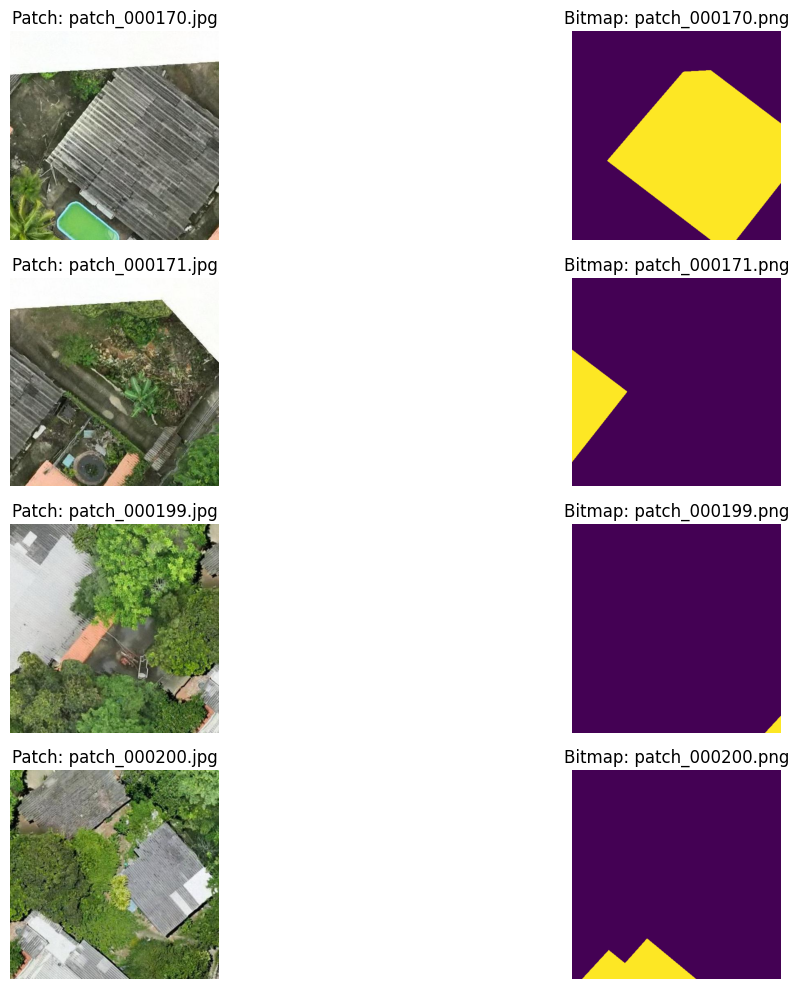

In [350]:
plot_pairwise_simple(l1[:4])

Plotting 8 pairs in 4 rows x 2 pairs per row


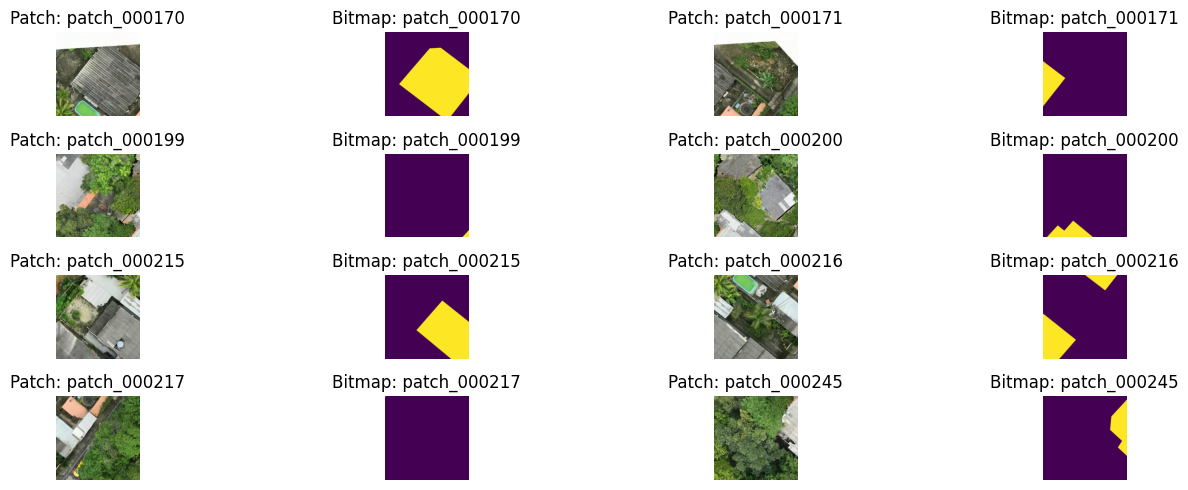

In [354]:
plot_pairwise(l1[:8])

In [93]:
px, py = ~transform * (bbox.bounds[0], bbox.bounds[1])
print(px,py)

7615.999999985099 9472.00000000745


In [86]:
patch_metadata[935]

{'patch_id': 935,
 'filename': 'patch_000935.jpg',
 'original_window': {'col_off': 6720,
  'row_off': 8960,
  'width': 512,
  'height': 512},
 'transform': [0.04017394834187174,
  0.0,
  -4818530.637432667,
  0.0,
  -0.04017394834187174,
  -2585519.6453014812],
 'crs': 'EPSG:3857',
 'bands': [1, 2, 3],
 'original_file': 'big-tiles/tile_1.tif',
 'original_transform': [0.04017394834187174,
  0.0,
  -4818800.606365525,
  0.0,
  -0.04017394834187174,
  -2585159.686724338]}

In [188]:
buildings.sindex.valid_query_predicates

{None,
 'contains',
 'contains_properly',
 'covered_by',
 'covers',
 'crosses',
 'dwithin',
 'intersects',
 'overlaps',
 'touches',
 'within'}

In [ ]:
cols_affine = ['transform_a', 'transform_b', 'transform_c', 'transform_d',
       'transform_e', 'transform_f']
args=intersection.loc[intersection["patch_id"]==292][cols].iloc[0].values

In [ ]:
from bitmap import generate_bitmaps_for_patches